# IMOS/AODN Long Time Series Products: Hourly time series (non-velocity)

**Eduardo Klein** - eduardo.kleinsalas at utas dot edu dot au

2019-10-23


## Background

IMOS support the Australian National Mooring Network, which is a facility that deploys and maintains moored oceanographic instruments all around Australia. The facility is independently run by five sub-facilities that are responsible for the QA/QC of the data. The data is stored in netCDF CF compliant files, one file per instrument per deployment per site. The files are accessible through [AODN THREDDS server](http://thredds.aodn.org.au/thredds/catalog/IMOS/catalog.html).


## The Problem

Depending on the user, some difficulties in accessing and processing the files could reduce the usability of the data: 

- The data is scattered across multiple files
- There are different levels of QC
- netCDF files are not the prefered format for biologist

So, to generate a long time series of for example, Temperature for one site, requires a relatively high level of expertise, collect many files from the server and concatenate it.

IMOS has decided to invest in the generation of a more "user friendly" products in order to facilitate the usability of the data by non-expert users --> LTSP series

- Aggregated time series: ONE variable from ALL instruments at ONE site
- Hourly time series: ALL variables from ALL instruments at ONE site, binned to 1hr fixed interval
- Gridded time series: ONE variable from ALL instruments at ONE sites binned to 1hr bins and 1m depth bins (more for the deep water moorings)




## The Format

To aggregate all instruments that has been deployed over the time at different depth requires a particular netCDF structure: [Indexed Ragged Array Representation](http://cfconventions.org/cf-conventions/v1.6.0/cf-conventions.html#_indexed_ragged_array_representation). 

This representation breaks the standard "rectangular" structure that has TIME as a common dimension with another structure that is indexed by "INSTRUMENT" and has "OBSERVATION" as a common dimension. `TIME` is now a variable in the file.


This format have some pros and cons:
 
 PROS:
 - all values from all deployments are in one single file.
 
 
 CONS: 
 - Not having `TIME` as a dimension require and understanding of the format and some "advanced" techniques to manipulate the data
 

## The Hourly time series: a working example




## The hourly product

Basically, the process to generate an Hourly aggregated time series is as follow:
1. Check the file for entry conditions: site_code, dates, depth, dimensions, etc
2. Discard out of the water records
3. Count QC flags -> indicator of the quality of the output
4. For each variable, resample the values into 1hr bins
    - Mean/median plus min, max, std, count
5. Add metadata
6. Save file

You can have the documentation and the code visiting the [python-aodn tools repository](https://github.com/aodn/python-aodntools/tree/master/aodntools/timeseries_products)


For this example, we will use python xarray and pandas packages. 

In [2]:
import datetime
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### The file structure

As mentioned before, all the deployments with its particular `NOMINAL_DEPTH` are aggregated into a single file. When integrating several deployments, you need to consider the different depths, so it is not possible to produce a continuous time series over a common time line. Thats why the ragged array structure. 

See for example this file from GBR Palm Passage(QLD). You can download the file directly from the THREDDS server:

In [3]:
file = 'http://thredds.aodn.org.au/thredds/dodsC/IMOS/ANMN/QLD/GBRPPS/hourly_timeseries/IMOS_ANMN-QLD_BOSTUZ_20071029_GBRPPS_FV02_hourly-timeseries-including-non-QC_END-20190524_C-20191010.nc'
nc = xr.open_dataset(file)
## see the data set structure
nc

<xarray.Dataset>
Dimensions:           (INSTRUMENT: 176, OBSERVATION: 697536)
Coordinates:
    TIME              (OBSERVATION) datetime64[ns] ...
    LONGITUDE         (INSTRUMENT) float64 ...
    LATITUDE          (INSTRUMENT) float64 ...
    NOMINAL_DEPTH     (INSTRUMENT) float32 ...
Dimensions without coordinates: INSTRUMENT, OBSERVATION
Data variables:
    instrument_index  (OBSERVATION) int32 ...
    instrument_id     (INSTRUMENT) |S64 ...
    source_file       (INSTRUMENT) |S64 ...
    DEPTH             (OBSERVATION) float32 ...
    DEPTH_count       (OBSERVATION) float32 ...
    DEPTH_min         (OBSERVATION) float32 ...
    DEPTH_max         (OBSERVATION) float32 ...
    DEPTH_std         (OBSERVATION) float32 ...
    CHLU              (OBSERVATION) float32 ...
    CHLU_count        (OBSERVATION) float32 ...
    CHLU_max          (OBSERVATION) float32 ...
    CHLU_min          (OBSERVATION) float32 ...
    CHLU_std          (OBSERVATION) float32 ...
    CPHL              (OBSE

Note the dimensions: `INSTRUMENT`, `OBSERVATION`.

`TIME` and `DEPTH` are variables

Note the ancillary statistical variables associated to each Variable of Interest (VoI).

In this particular example, the aggregated files contain quality controlled values *and* no QC values as well. In this case, an additional attribute specifying the percent of QC values is included for each VoI.

See that `TEMP` has been 100% QCed while `TURB` no:

In [4]:
nc.TEMP.attrs

OrderedDict([('ancillary_variables', 'TEMP_min TEMP_max TEMP_std TEMP_count'),
             ('long_name', 'mean sea_water_temperature'),
             ('standard_name', 'sea_water_temperature'),
             ('units', 'degrees_Celsius'),
             ('valid_max', 40.0),
             ('valid_min', -2.5),
             ('cell_methods',
              'TIME:mean (interval: 1 hr comment: time mid point)'),
             ('percent_quality_controlled', 100.0)])

In [5]:
nc.TURB.attrs

OrderedDict([('ancillary_variables', 'TURB_min TURB_max TURB_std TURB_count'),
             ('long_name', 'median sea_water_turbidity'),
             ('standard_name', 'sea_water_turbidity'),
             ('units', '1'),
             ('valid_max', 1000.0),
             ('valid_min', 0.0),
             ('cell_methods',
              'TIME:median (interval: 1 hr comment: time mid point)'),
             ('percent_quality_controlled', 0.0)])

### Time Series Plot

If you plot `TEMP` along `TIME` variable, you will have all the instruments mixed together. remember that in one particular deployment is frequent to have more than one instrument moored at different depths.

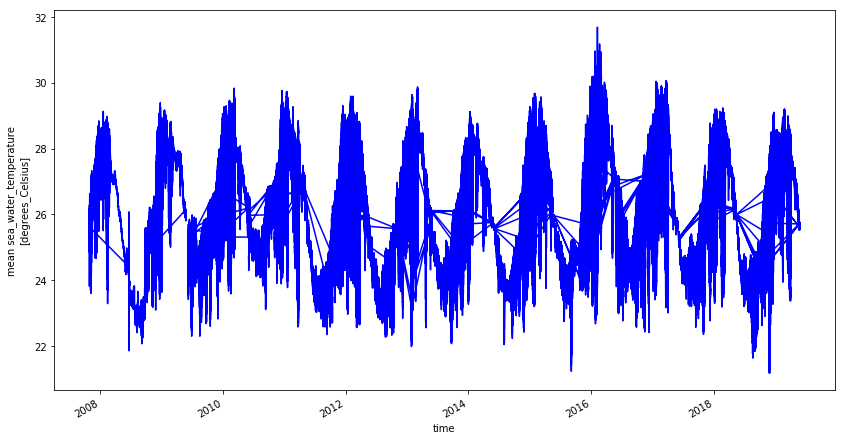

In [7]:
nc.TEMP.plot.line(x='TIME', color='blue', aspect=2, size=7)

As `OBSERVATION` is the only dimension for `TEMP`, you need to work the variables as a grouped object.`xarray` and `pandas` work nicely with groups, although pandas could be more flexible and normally faster.

In the file, each value has an associated variable called `instrument_index` that indicates the id of the instrument were the observation came from. In the data set, `INSTRUMENT` and `instrument_id` will allow you to make the link between the instrument index and the instrument description (name, model, serial number).

But first, let's extract `TEMP`, `PSAL`, `DEPTH`, `TIME` and `instrument_index` from the nc dataset to a pandas data frame (DF). 

**NOTE**: the hourly aggregated time series files are normally large files. If you try to convert all the VoI and statistical ancillary variables into a pandas DF using a jupyter notebook, you will probably face memory problems. So try to work few variables at the same time.

In [111]:
df = pd.DataFrame({'instrument_index': nc.instrument_index, 
                   'TIME': nc.TIME, 
                   'TEMP': nc.TEMP, 
                   'PSAL': nc.PSAL, 
                   'DEPTH': nc.DEPTH})

df.describe()

,instrument_index,TEMP,PSAL,DEPTH
count,697536.000000,602992.000000,134189.000000,670289.000000
mean,89.878520,25.997171,35.259949,41.306622
std,51.827089,1.709366,0.240877,21.270319
min,0.000000,21.178961,33.666645,2.492166
25%,43.000000,24.554998,35.146530,20.829317
50%,92.000000,25.793499,35.295959,39.076611
75%,135.000000,27.465158,35.410400,60.282490
max,175.000000,31.684771,35.752789,73.421074


In [101]:
## how many intruments?
df.instrument_index.unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175])

This file has 176 individual instruments, each of them with a registered `NOMINAL_DEPTH` 



If we plot the variable `TEMP` along the `TIME` variable we will have a plot in were each colour represents an individual deployment. For that we need to group the table by `instrument_index`:

In [104]:
df_grouped = df.groupby('instrument_index')

and make a plot...

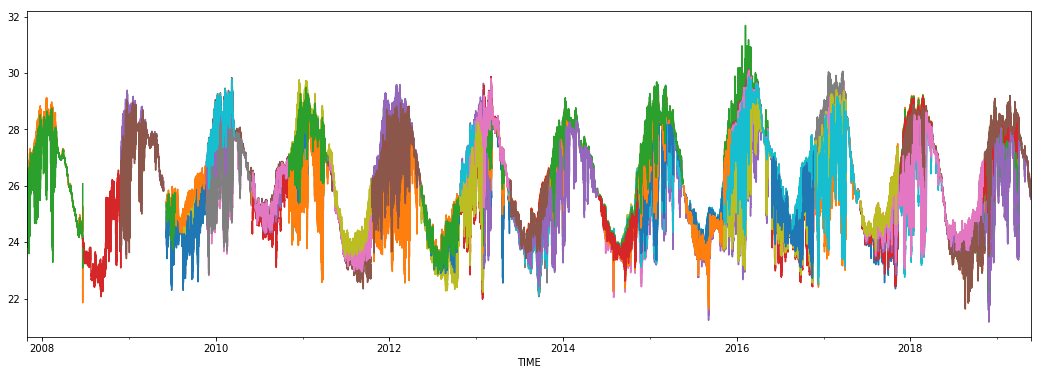

In [37]:
fig, ax = plt.subplots(figsize=(18,6))

for name, group in df_grouped:
    group.plot(x='TIME', y='TEMP', ax=ax, label=name)

ax.get_legend().remove()
plt.show()

Each colour represent one instrument deployed at one particular depth. 

It may be interesting to group the nominal depth values to have long time series at that particular depth range. The `NOMINAL_DEPTH` is a coordinate with `INSTRUMENT` dimension, which in fact is the link to `instrument_index` variable. Let's explore `NOMINAL_DEPTH` extracting the values into another data frame (and name `INSTRUMENT` as `instrument_index` to join this table after with our first data frame)


In [14]:
df_depth = pd.DataFrame({'instrument_index': nc.INSTRUMENT, 'NOMINAL_DEPTH': nc.NOMINAL_DEPTH})
df_depth

,instrument_index,NOMINAL_DEPTH
0,0,53.000000
1,1,21.000000
2,2,35.000000
3,3,56.500000
4,4,26.000000
5,5,34.000000
6,6,61.000000
7,7,50.500000
8,8,22.500000
9,9,57.500000


In [16]:
df_depth.describe()

,instrument_index,NOMINAL_DEPTH
count,176.000000,176.000000
mean,87.500000,41.303761
std,50.950957,21.520672
min,0.000000,1.000000
25%,43.750000,21.500000
50%,87.500000,39.500000
75%,131.250000,60.599998
max,175.000000,71.739998


as you can see, there are 176 instruments, deployed between 1m and 71.74 meters depth. 

Now add the depth bins to the data table:


In [105]:
df = df.join(df_depth.set_index('instrument_index'), on='instrument_index')


Suppose we decide to group the `NOMINAL_DEPTH` into 10m bins. for that we will create a new variable (as IntervalIndex) called `DEPTH_bin`: 

In [106]:
bins = pd.IntervalIndex.from_tuples([(0, 10), (10, 20), (20, 30), (30, 40), (40, 50), (50, 60), (60, 70), (70, 80)])
df['DEPTH_bin'] = pd.cut(df['NOMINAL_DEPTH'], bins)

In [107]:
df

,instrument_index,TIME,TEMP,PSAL,DEPTH,NOMINAL_DEPTH,DEPTH_bin
0,0,2007-10-29 10:00:00,NaN,NaN,NaN,53.0,"(50, 60]"
1,0,2007-10-29 11:00:00,NaN,NaN,NaN,53.0,"(50, 60]"
2,0,2007-10-29 12:00:00,NaN,NaN,NaN,53.0,"(50, 60]"
3,0,2007-10-29 13:00:00,NaN,NaN,NaN,53.0,"(50, 60]"
4,0,2007-10-29 14:00:00,NaN,NaN,NaN,53.0,"(50, 60]"
5,0,2007-10-29 15:00:00,NaN,NaN,NaN,53.0,"(50, 60]"
6,0,2007-10-29 16:00:00,NaN,NaN,NaN,53.0,"(50, 60]"
7,0,2007-10-29 17:00:00,NaN,NaN,NaN,53.0,"(50, 60]"
8,0,2007-10-29 18:00:00,NaN,NaN,NaN,53.0,"(50, 60]"
9,0,2007-10-29 19:00:00,NaN,NaN,NaN,53.0,"(50, 60]"


and now we can group by `DEPTH_bin` and make a new plot:


In [108]:
df_grouped = df.groupby('DEPTH_bin')

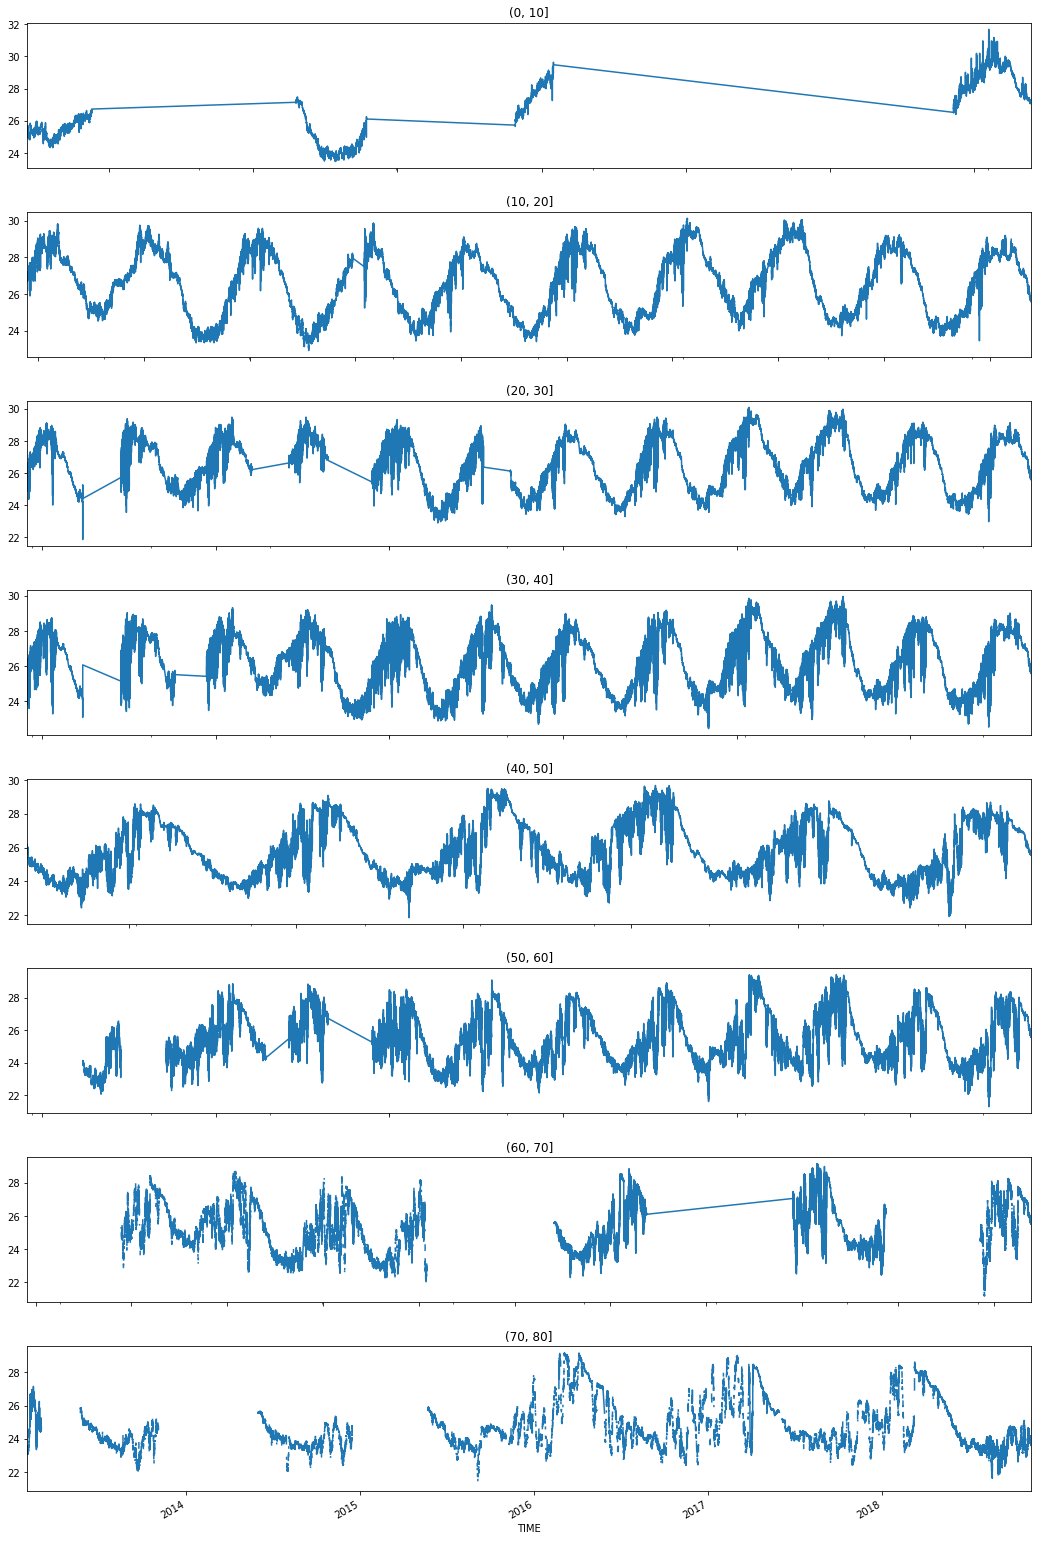

In [99]:
fig, ax = plt.subplots(nrows, ncols, figsize = (18,30), sharex='col', sharey='row')

for i, (name, group) in enumerate(df_grouped):
    ax = plt.subplot(nrows, ncols, i+1)
    group.plot(x='TIME', y='TEMP', ax=ax, sharex=True, sharey=True)
    ax.set_title(name)
    ax.get_legend().remove()

plt.subplots_adjust(hspace=0.3)
plt.show()

And also have a descriptive statistics table by DEPTH group:

In [91]:
df_grouped.TEMP.describe()

,count,mean,std,min,25%,50%,75%,max
DEPTH_bin,,,,,,,,
"(0, 10]",15298.0,26.565630,1.824614,23.480000,25.051247,26.335304,28.063686,31.684771
"(10, 20]",142102.0,26.560312,1.724532,22.909971,24.935200,26.647127,28.170385,30.136337
"(20, 30]",85056.0,26.592339,1.602940,21.859316,25.090294,26.840942,27.987442,30.097284
"(30, 40]",124963.0,26.122183,1.558899,22.452131,24.756332,26.087538,27.447521,29.968920
"(40, 50]",51644.0,25.801514,1.608971,21.852430,24.407987,25.543642,27.214591,29.674383
"(50, 60]",86873.0,25.407511,1.544209,21.301977,24.177792,25.114746,26.659023,29.412313
"(60, 70]",53610.0,25.318672,1.502346,21.178961,24.144718,25.169582,26.482178,29.165045
"(70, 80]",43446.0,24.662991,1.424444,21.239237,23.644037,24.262308,25.297695,29.180546


### Plot Temperature and Salinity

In the same way, we can plot two variables as they are stored in the same file. We've already stored temperature and salinity in the data frame. Let's use the same depth range we've used for the temperature plot. Any empty plot indicates the absence of salinity register at that particular depth range

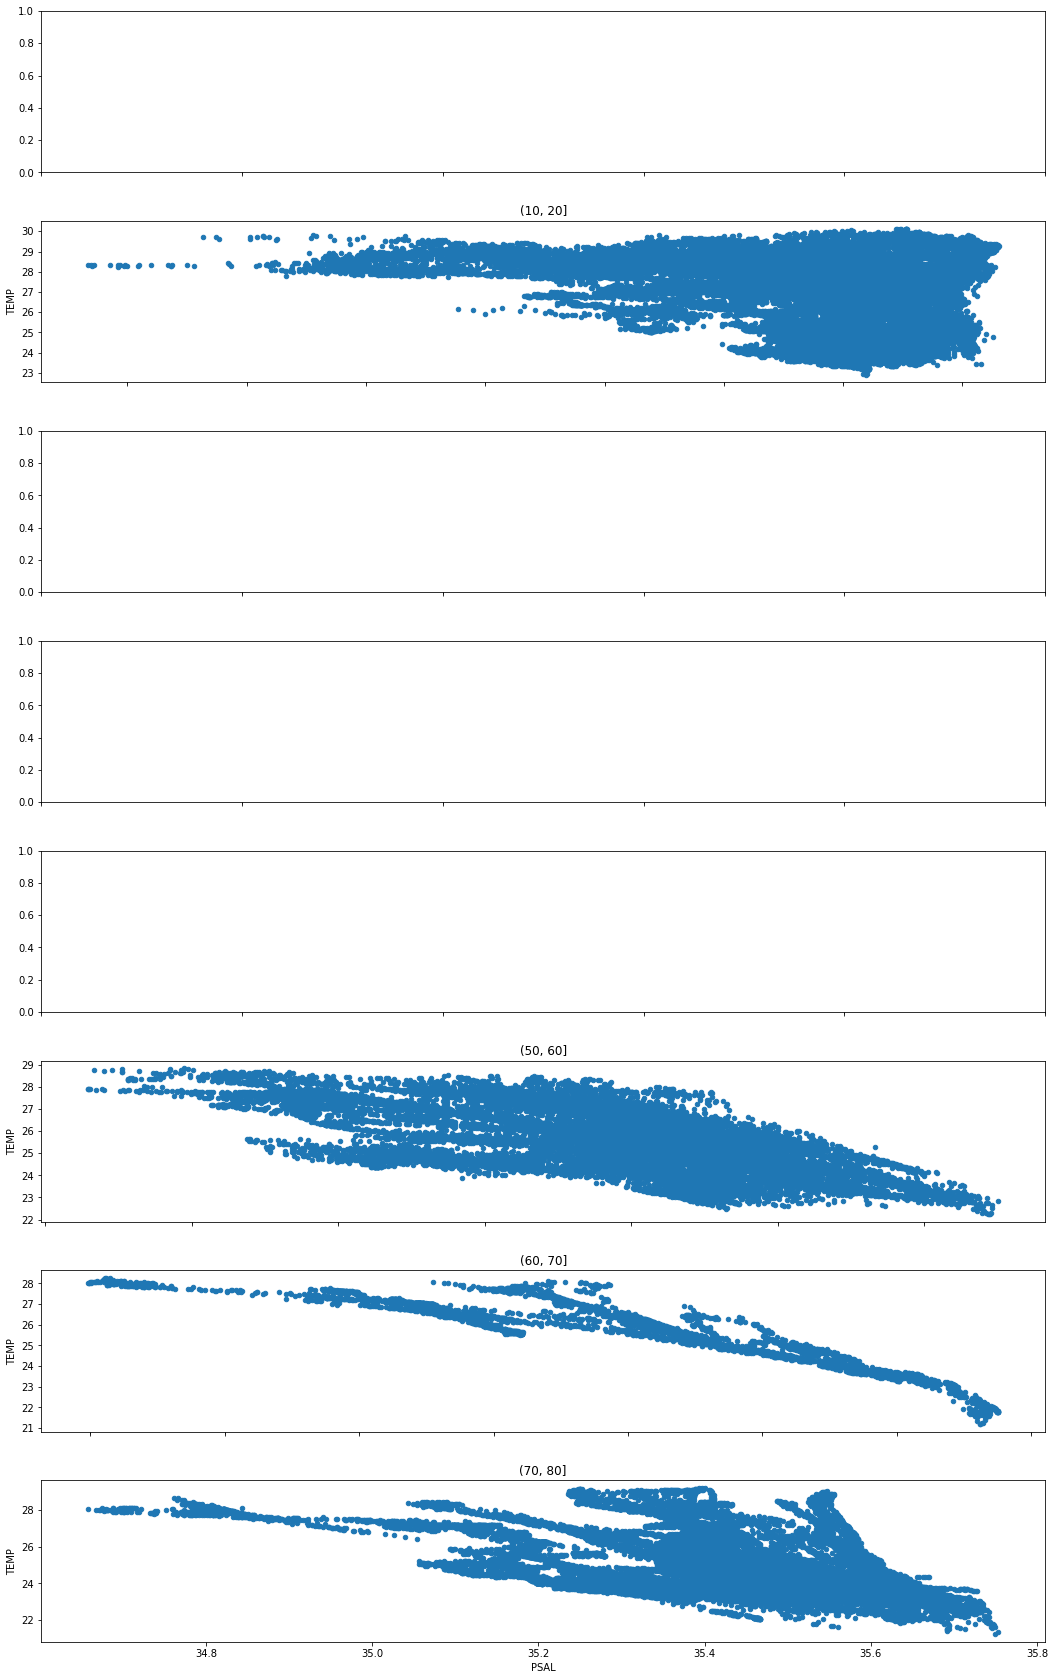

In [122]:
fig, ax = plt.subplots(nrows, ncols, figsize = (18,30), sharex='col', sharey='row')

for i, (name, group) in enumerate(df_grouped):
    ## check for full PSAL NaN in the group
    if not group.PSAL.isnull().values.all():
        ax = plt.subplot(nrows, ncols, i+1)
        group.plot.scatter(x='PSAL', y='TEMP', ax=ax, sharex=True, sharey=True)
        ax.set_title(name)

plt.subplots_adjust(hspace=0.3)
plt.show()

## Summary

- the *Hourly Time Series Aggregated product* is available for each of the IMOS sites at [AODN THREDDS server  ](http://thredds.aodn.org.au/thredds/catalog/IMOS/catalog.html).
- All variables measured in each of the sites are aggregated into one file with a common one-hour time interval and ancillary statistical variables for each time bin.
- The aggregated file has a indexed ragged array structure, where the variable dimension is `OBSERVATION` and the source of the measurement is identified by the variable `instrument_index`.  
- the `NOMINAL_DEPTH` of each instrument is stored in the file as a variable with `INSTRUMENT` dimension. This will allow to link the variable values through the link `instrument_index`= `INSTRUMENT`.  
- It is possible to produce a long time series of any variables grouping the records by `instrument_index` which can be associated to the `NOMINAL_DEPTH` of the source instrument.
  
